# CarND-Vehicle Detection

## The goal of this project is to detect the vehicles in the images. This program extracts the HOG, color histogram and binned color features. These features are used to train a SVM classifier.

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
from random import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

## Extract Features from Training Data Set

In [2]:
# Define a function to compute the HOG feature
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=feature_vec, 
                          block_norm='L2')
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=False, feature_vector=feature_vec,
                          block_norm='L2')
        return features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the three channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

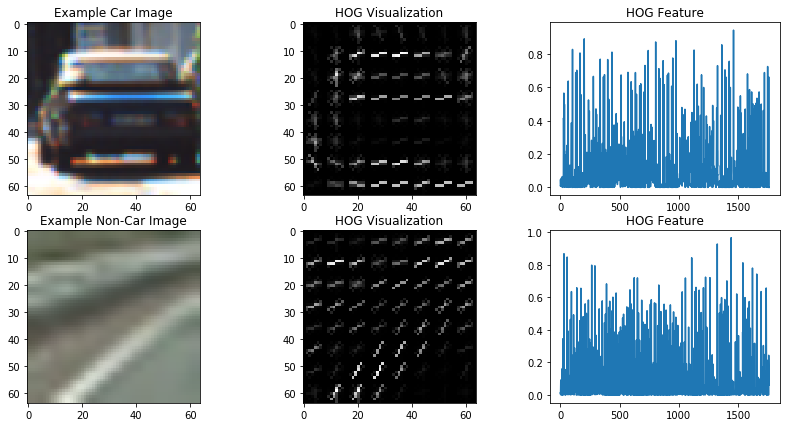

In [5]:
# Read the car and non-car test images and calculate the HOG features
car_img=mpimg.imread('vehicles/KITTI_extracted/1.png')
noncar_img=mpimg.imread('non-vehicles/GTI/image6.png')

car_gray=cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
noncar_gray=cv2.cvtColor(noncar_img, cv2.COLOR_RGB2GRAY)
# Set the parameters for HOG
orient=9
pix_per_cell=8
cell_per_block=2
car_features, car_hog_img=get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features, noncar_hog_img=get_hog_features(noncar_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
# Plot the examples
fig = plt.figure()
fig = plt.subplots(2,3, figsize=(14, 7))
plt.subplot(231)
plt.imshow(car_img)
plt.title('Example Car Image')
plt.subplot(232)
plt.imshow(car_hog_img, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(233)
plt.plot(car_features)
plt.title('HOG Feature')
plt.subplot(234)
plt.imshow(noncar_img)
plt.title('Example Non-Car Image')
plt.subplot(235)
plt.imshow(noncar_hog_img, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(236)
plt.plot(noncar_features)
plt.title('HOG Feature')


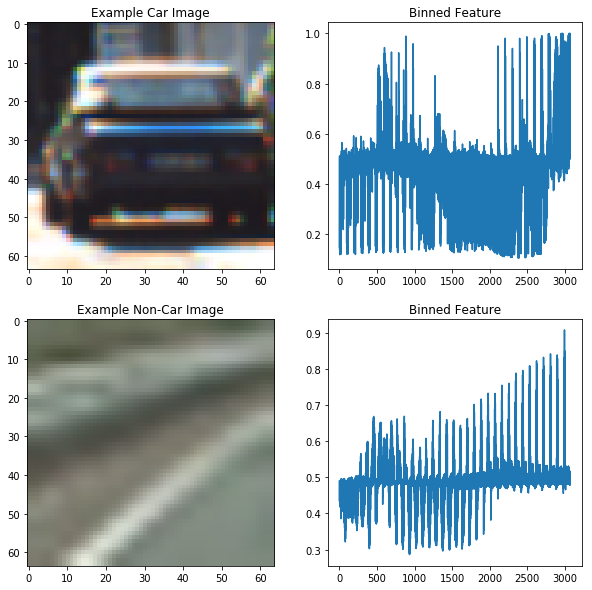

In [6]:
# Read the car and non-car test images and calculate the binned color features
car_img=mpimg.imread('vehicles/KITTI_extracted/1.png')
noncar_img=mpimg.imread('non-vehicles/GTI/image6.png')

car_img_ycc=cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
noncar_img_ycc=cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YCrCb)
car_bin = bin_spatial(car_img_ycc, size=(32, 32))
noncar_bin = bin_spatial(noncar_img_ycc, size=(32, 32))
# Plot the examples
fig = plt.figure()
fig = plt.subplots(2,2, figsize=(10, 10))
plt.subplot(221)
plt.imshow(car_img)
plt.title('Example Car Image')
plt.subplot(222)
plt.plot(car_bin)
plt.title('Binned Feature')
plt.subplot(223)
plt.imshow(noncar_img)
plt.title('Example Non-Car Image')
plt.subplot(224)
plt.plot(noncar_bin)
plt.title('Binned Feature')


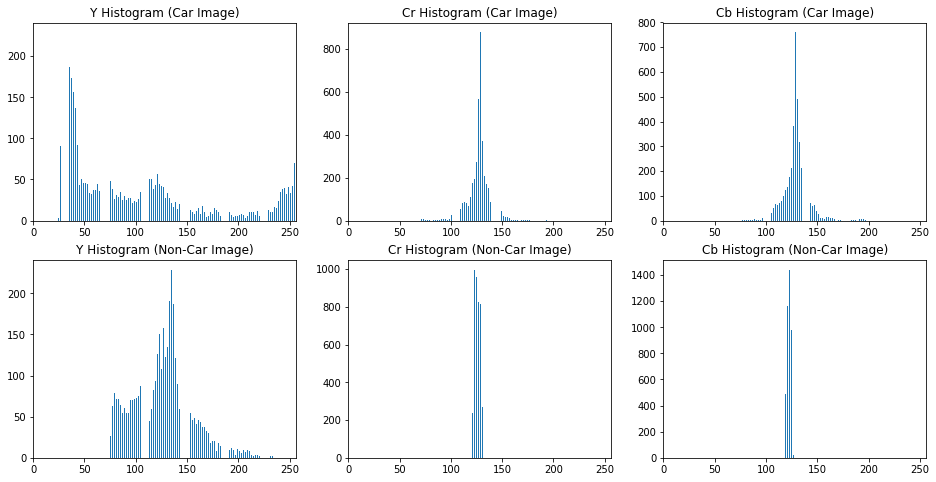

In [7]:
# Read the car and non-car test images and calculate the color histogram features
car_img=mpimg.imread('vehicles/KITTI_extracted/1.png')
noncar_img=mpimg.imread('non-vehicles/GTI/image6.png')
car_img_ycc=cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
noncar_img_ycc=cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YCrCb)

ch1_car, ch2_car, ch3_car, bincen_car, feature_vec_car = color_hist(car_img_ycc*255, nbins=128, bins_range=(0, 256))
ch1_noncar, ch2_noncar, ch3_noncar, bincen_noncar, feature_vec_noncar = color_hist(noncar_img_ycc*255, nbins=128, bins_range=(0, 256))
fig = plt.figure(figsize=(16,8))
plt.subplot(231)
plt.bar(bincen_car, ch1_car[0])
plt.xlim(0, 256)
plt.title('Y Histogram (Car Image)')
plt.subplot(232)
plt.bar(bincen_car, ch2_car[0])
plt.xlim(0, 256)
plt.title('Cr Histogram (Car Image)')
plt.subplot(233)
plt.bar(bincen_car, ch3_car[0])
plt.xlim(0, 256)
plt.title('Cb Histogram (Car Image)')
plt.subplot(234)
plt.bar(bincen_noncar, ch1_noncar[0])
plt.xlim(0, 256)
plt.title('Y Histogram (Non-Car Image)')
plt.subplot(235)
plt.bar(bincen_noncar, ch2_noncar[0])
plt.xlim(0, 256)
plt.title('Cr Histogram (Non-Car Image)')
plt.subplot(236)
plt.bar(bincen_noncar, ch3_noncar[0])
plt.xlim(0, 256)
plt.title('Cb Histogram (Non-Car Image)')

## Combine Features

In [8]:
# Define a function to extract the HOG, color histogram and binned color features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)    
        #Convert the scale from (0,1) to (0,255) for the png format
        feature_image=feature_image
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            ch1, ch2, ch3, bincen, hist_features = color_hist(feature_image*255, nbins=hist_bins, bins_range=(0, 256))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

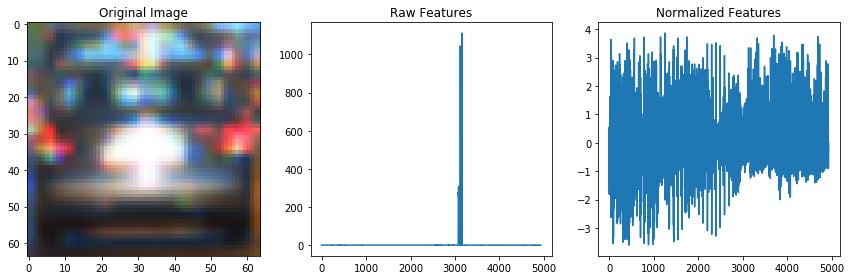

In [9]:
car_images = glob.glob('vehicles/KITTI_extracted/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')
shuffle(car_images)
shuffle(noncar_images)

cars = []
noncars = []
for image in car_images:
        cars.append(image)
for image in noncar_images:
        noncars.append(image)
    
sample_size = 10
cars = cars[0:sample_size]
noncars = noncars[0:sample_size]

    
car_features=extract_features(cars, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True)
noncar_features=extract_features(noncars, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True)
# Fit a per-column scaler
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Plot an example of raw and scaled features
car_ind=1
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## Train a Classifier 

In [10]:
# Read in car and non-car images from the dataset
car_images = glob.glob('vehicles/KITTI_extracted/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')
shuffle(car_images)
shuffle(noncar_images)

cars = []
noncars = []
for image in car_images:
        cars.append(image)
for image in noncar_images:
        noncars.append(image)
print('Number of car images:', len(cars)) 
print('Number of noncar images', len(noncars)) 
# Reduce the sample size because HOG features are slow to compute
sample_size = 5000
cars = cars[0:sample_size]
noncars = noncars[0:sample_size]

Number of car images: 5966
Number of noncar images 8968


In [11]:
# Parameters Tuning
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32

t=time.time()
car_features=extract_features(cars, color_space=colorspace, spatial_size=(spatial, spatial),
                                  hist_bins=histbin, orient=orient, 
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                  spatial_feat=True, hist_feat=True, hog_feat=True)
noncar_features=extract_features(noncars, color_space=colorspace, spatial_size=(spatial, spatial),
                                    hist_bins=histbin, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=True, hist_feat=True, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

61.24 Seconds to extract features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
2.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9975


## Define Sliding Windows on an Image

In [12]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

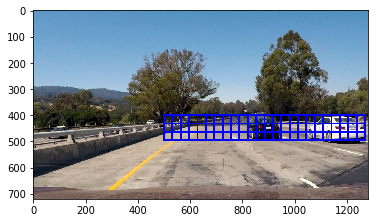

In [14]:
# Apply the sliding window function to a test image
image=mpimg.imread('test_images/test1.jpg')
x_start1=500
x_stop1=1280
y_start1=400
y_stop1=500
windows1 = slide_window(image, x_start_stop=[x_start1, x_stop1], y_start_stop=[y_start1, y_stop1], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

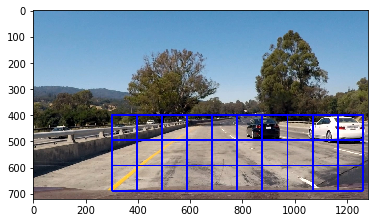

In [15]:
# Apply the sliding window function to a test image
image=mpimg.imread('test_images/test1.jpg')
x_start2=300
x_stop2=1280
y_start2=400
y_stop2=720
windows2 = slide_window(image, x_start_stop=[x_start2, x_stop2], y_start_stop=[y_start2, y_stop2], 
                    xy_window=(192, 192), xy_overlap=(0.5, 0.5))
                      
window_img = draw_boxes(image, windows2, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Search and Classify on an Image

In [16]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        ch1, ch2, ch3, bincen, hist_features = color_hist(feature_image*255, nbins=hist_bins, bins_range=(0, 256))
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [17]:

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [18]:
# Search and classify on a test image
# Read image
images=glob.glob('test_images/test*.jpg')
for img in images:
    pname= img.split('\\')[-1]
    image = mpimg.imread(img)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    # Parameter Tuning
    x_start_stop = [300, 1280]
    y_start_stop_1 = [390, 500] # Min and max in y to search in slide_window()
    y_start_stop_2 = [395, 500] # Min and max in y to search in slide_window()
    y_start_stop_3 = [405, 700] # Min and max in y to search in slide_window()
    y_start_stop_4 = [410, 700] # Min and max in y to search in slide_window()
    

    windows1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_1, 
                        xy_window=(48, 48), xy_overlap=(0.75, 0.75))
    windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_2, 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_3, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows4 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_4, 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    win=windows1+windows2+windows3+windows4
    hot_windows = search_windows(image, win, svc, X_scaler, color_space=colorspace, 
                            spatial_size=(spatial, spatial), hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, 
                            hist_feat=True, hog_feat=True)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    window_img=cv2.cvtColor(window_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/'+pname, window_img)

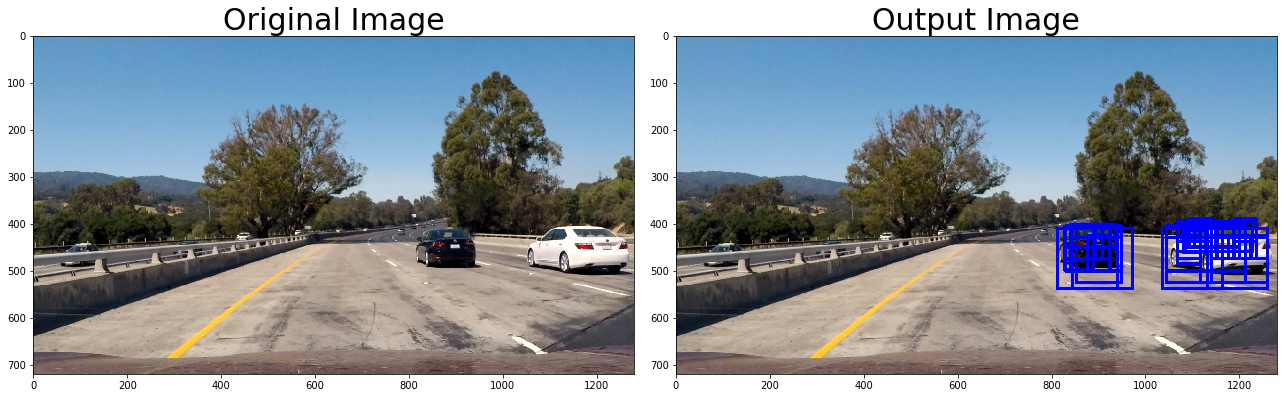

In [19]:
origin_image=mpimg.imread('test_images/test1.jpg')
output_image=mpimg.imread('output_images/test1.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
plt.tight_layout()
ax1.imshow(origin_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(output_image)
ax2.set_title('Output Image', fontsize=30)

## Heat Map

In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 8)
    # Return the image
    return img

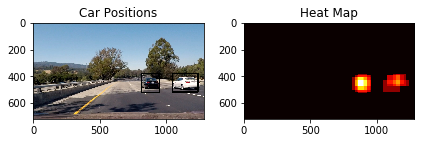

In [21]:
# Draw heat map on a single image
image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

image = image.astype(np.float32)/255
# Parameter Tuning
x_start_stop = [300, 1280]
y_start_stop_1 = [360, 500] # Min and max in y to search in slide_window()
y_start_stop_2 = [380, 700] # Min and max in y to search in slide_window()
y_start_stop_3 = [390, 700] # Min and max in y to search in slide_window()
y_start_stop_4 = [400, 700] # Min and max in y to search in slide_window()


windows1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_1, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_2, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_3, 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows4 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_4, 
                    xy_window=(196, 196), xy_overlap=(0.75, 0.75))
win=windows1+windows2+windows3+windows4

hot_windows = search_windows(image, win, svc, X_scaler, color_space=colorspace, 
                        spatial_size=(spatial, spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)                       

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## HOG Subsampling Window Search
#### This is a more efficient method which extracts the HOG just once for each full image. 

In [22]:
def find_cars(img, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # Select the region of interest for the window search
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1]]
    # Color conversion
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    # Change the scale of the search window
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Read the values on each color channel
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps 
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Create an array to receive the positive detected windows
    bboxes=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            if hog_channel == 0:
                hog_features = hog_feat1
            if hog_channel == 1:
                hog_features = hog_feat2      
            if hog_channel == 2:
                hog_features = hog_feat3  

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            ch1, ch2, ch3, bincen, hist_features = color_hist(subimg*255, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
               
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox=((xbox_left+x_start_stop[0], ytop_draw+y_start_stop[0]),(xbox_left+win_draw+x_start_stop[0],ytop_draw+win_draw+y_start_stop[0]))
                bboxes.append(bbox)
    return bboxes

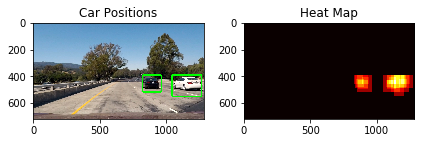

In [24]:

orient=11
hog_channel="ALL"
pixel_per_cell=16
cell_per_block=2
spatial_size=(32,32)
hist_bins=32


image = mpimg.imread('test_images/test1.jpg')
    
scale1=0.8
x_start_stop1=[500,1280]
y_start_stop1=[380, 500]
bboxes1=find_cars(image, x_start_stop1, y_start_stop1, scale1, svc, X_scaler, 
                 orient, hog_channel, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins)
scale2=1
x_start_stop2=[485,1280]
y_start_stop2=[385, 500]
bboxes2=find_cars(image, x_start_stop2, y_start_stop2, scale2, svc, X_scaler, 
                 orient, hog_channel, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins)
scale3=1.1
x_start_stop3=[470,1280]
y_start_stop3=[390, 500]
bboxes3=find_cars(image, x_start_stop3, y_start_stop3, scale3, svc, X_scaler, 
                 orient, hog_channel, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins)
scale4=1.5
x_start_stop4=[400,1280]
y_start_stop4=[390, 720]
bboxes4=find_cars(image, x_start_stop4, y_start_stop4, scale4, svc, X_scaler, 
                 orient, hog_channel, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins)
scale5=2
x_start_stop5=[400,1280]
y_start_stop5=[390, 720]
bboxes5=find_cars(image, x_start_stop5, y_start_stop5, scale5, svc, X_scaler, 
                 orient, hog_channel, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins)
scale6=2.5
x_start_stop6=[400,1280]
y_start_stop6=[390, 720]
bboxes6=find_cars(image, x_start_stop6, y_start_stop6, scale6, svc, X_scaler, 
                 orient, hog_channel, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins)

bboxes=bboxes1+bboxes2+bboxes3+bboxes4+bboxes5+bboxes6

window_img = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)                    


heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Create the pipeline for video processing

In [25]:
# Define a class to store the result data
class detection_result():
    def __init__(self):
        # history of rectangles previous n frames
        self.bboxes = [] 
        
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        if len(self.bboxes) > 15:
            # throw out oldest rectangle set(s)
            self.bboxes = self.bboxes[len(self.bboxes)-15:]

In [29]:
def process(image):
    # Parameters
    orient=11
    hog_channel="ALL"
    pixel_per_cell=16
    cell_per_block=2
    spatial_size=(32,32)
    hist_bins=32
    
    scale1=0.8
    x_start_stop1=[600,1280]
    y_start_stop1=[380, 500]
    bboxes1=find_cars(image, x_start_stop1, y_start_stop1, scale1, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)
    scale2=0.9
    x_start_stop2=[600,1280]
    y_start_stop2=[395, 500]
    bboxes2=find_cars(image, x_start_stop2, y_start_stop2, scale2, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)
    scale3=1
    x_start_stop3=[485,1280]
    y_start_stop3=[390, 500]
    bboxes3=find_cars(image, x_start_stop3, y_start_stop3, scale3, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)
    scale4=1.1
    x_start_stop4=[470,1280]
    y_start_stop4=[395, 500]
    bboxes4=find_cars(image, x_start_stop4, y_start_stop4, scale4, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)
    scale5=1.5
    x_start_stop5=[400,1280]
    y_start_stop5=[395, 720]
    bboxes5=find_cars(image, x_start_stop5, y_start_stop5, scale5, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)
    scale6=2
    x_start_stop6=[400,1280]
    y_start_stop6=[395, 720]
    bboxes6=find_cars(image, x_start_stop6, y_start_stop6, scale6, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)
    scale7=2.5
    x_start_stop7=[400,1280]
    y_start_stop7=[395, 720]
    bboxes7=find_cars(image, x_start_stop7, y_start_stop7, scale7, svc, X_scaler, 
                     orient, hog_channel, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins)

    bboxes=bboxes1+bboxes2+bboxes3+bboxes4+bboxes5+bboxes6+bboxes7

    # add detections to the history
    if len(bboxes) > 0:
        det.add_bboxes(bboxes)
    
    # Initiate a heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in bounding box list
    for bbox in det.bboxes:
        heat = add_heat(heat, bbox)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    
    return draw_labeled_bboxes(np.copy(image), labels)

## Video Processing

In [30]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [40]:
det = detection_result()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [03:48<00:04,  4.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 3min 57s


In [32]:
det = detection_result()

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:06<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 21min 7s
